
# Предсказание музыкальных жанров

## Шаг 1. Загрузка и изучение данных

Произведем необходимые импорты

In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

!pip install feature-engine -q
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV
)

from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler,
    OneHotEncoder, OrdinalEncoder, LabelEncoder,
    PolynomialFeatures
)

from sklearn.metrics import (
    make_scorer,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    f1_score
)

plt.rcParams["figure.figsize"] = (10, 6)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/328.9 kB ? eta -:--:--
     ━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/328.9 kB 1.1 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 327.7/328.9 kB 4.5 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.9/328.9 kB 3.7 MB/s eta 0:00:00


Создадим функции для работы

In [ ]:
# функция вывода информации о датасете
def dataset_info(dataset):
    display(dataset.info())
    display(dataset.describe())
    display(dataset.head())

In [ ]:
# функция для проверки на дубликаты и вывода значений
def get_duplcate():

    dataframes = {
        'train': train,
        'test': test,
        'sample_submit': sample_submit
    }

    for name, df in dataframes.items():
        print(
            f'Дубликатов в датафрейме {name}:',
            df.duplicated().sum(), '- это',
            round((df.duplicated().sum() / len(df)), 2), 'от всех данных'
    )

Загрузим данные

In [ ]:
pd.set_option('display.max_columns', None) # установим опцию по выводу всех колонок датафрейма

# укажем формат отображения больших чисел,
pd.set_option('display.float_format', '{:.2f}'.format) # чтобы не применялась экспоненциальная запись в таблицах

In [ ]:
# прочитаем файлы
train = pd.read_csv('./kaggle_music_genre_train.csv', sep= ',')
test = pd.read_csv('./kaggle_music_genre_test.csv', sep= ',')
sample_submit = pd.read_csv('./sample_submission.csv', sep= ',')

### Изучим общую информацию о каждом датафрейме

In [ ]:
dataset_info(train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       40000 non-null  int64  
 1   track_name        29324 non-null  object 
 2   popularity        36063 non-null  float64
 3   acousticness      40000 non-null  float64
 4   danceability      37954 non-null  float64
 5   duration_ms       40000 non-null  float64
 6   energy            40000 non-null  float64
 7   instrumentalness  40000 non-null  float64
 8   key               38624 non-null  object 
 9   liveness          40000 non-null  float64
 10  loudness          40000 non-null  float64
 11  mode              38174 non-null  object 
 12  speechiness       40000 non-null  float64
 13  tempo             40000 non-null  object 
 14  obtained_date     33738 non-null  object 
 15  valence           40000 non-null  float64
 16  music_genre       40000 non-null  object

None

,instance_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,valence
count,40000.00,36063.00,40000.00,37954.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00
mean,26050.12,44.13,0.31,0.56,221080.78,0.60,0.18,0.19,-11.67,0.13,0.46
std,14441.50,15.56,0.34,0.18,129611.78,0.26,0.33,0.16,14.51,0.21,0.25
min,1000.00,0.00,0.00,0.06,-1.00,0.00,0.00,0.01,-108.36,0.02,0.00
25%,13554.75,34.00,0.02,0.44,174793.75,0.43,0.00,0.10,-11.53,0.04,0.26
50%,26079.50,45.00,0.14,0.57,219142.00,0.64,0.00,0.13,-7.46,0.05,0.45
75%,38562.25,55.00,0.55,0.69,268480.00,0.82,0.15,0.24,-5.25,0.11,0.65
max,50999.00,99.00,1.00,0.99,4830606.00,1.00,0.99,1.00,1.95,1.89,0.99


,instance_id,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,28097,NaN,38.00,0.05,NaN,152427.00,0.64,0.02,F#,0.11,-9.11,Minor,0.06,167.357,4-Apr,0.60,Country
1,49793,Uber Everywhere,67.00,0.05,0.78,-1.00,0.46,0.00,C#,0.18,-15.03,Major,0.28,140.181,4-Apr,0.20,Rap
2,41545,Love Is All,37.00,0.58,0.66,311008.00,0.65,0.06,D,0.40,-7.74,Minor,0.03,?,NaN,0.69,Jazz
3,23453,NaN,69.00,0.01,0.68,200000.00,0.60,0.00,E,0.11,-7.20,Minor,0.03,120.052,4-Apr,0.30,Hip-Hop
4,33933,Should Have Known Better,64.00,0.98,0.57,307698.00,0.17,0.28,G,0.12,-20.70,Major,0.03,90.97200000000001,4-Apr,0.30,Rock


In [ ]:
dataset_info(test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       10000 non-null  int64  
 1   track_name        7326 non-null   object 
 2   popularity        9002 non-null   float64
 3   acousticness      10000 non-null  float64
 4   danceability      9486 non-null   float64
 5   duration_ms       10000 non-null  float64
 6   energy            10000 non-null  float64
 7   instrumentalness  10000 non-null  float64
 8   key               9626 non-null   object 
 9   liveness          10000 non-null  float64
 10  loudness          10000 non-null  float64
 11  mode              9491 non-null   object 
 12  speechiness       10000 non-null  float64
 13  tempo             10000 non-null  object 
 14  obtained_date     8462 non-null   object 
 15  valence           10000 non-null  float64
dtypes: float64(10), int64(1), object(5)
memor

None

,instance_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,valence
count,10000.00,9002.00,10000.00,9486.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,25797.03,44.53,0.31,0.56,221939.91,0.60,0.18,0.19,-11.60,0.13,0.45
std,14402.40,15.39,0.34,0.18,124845.90,0.26,0.33,0.16,14.26,0.22,0.25
min,1012.00,0.00,0.00,0.06,-1.00,0.00,0.00,0.01,-104.18,0.02,0.02
25%,13238.50,34.00,0.02,0.44,174846.50,0.43,0.00,0.10,-11.56,0.04,0.26
50%,25704.50,45.00,0.15,0.57,220362.00,0.64,0.00,0.12,-7.48,0.05,0.44
75%,38237.00,56.00,0.55,0.69,268947.50,0.81,0.15,0.24,-5.25,0.12,0.65
max,50988.00,96.00,1.00,0.98,2294000.00,1.00,1.00,0.99,3.74,1.79,0.99


,instance_id,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
0,32911,Pretty Green,30.00,0.09,0.43,249640.00,0.86,0.00,D,0.16,-5.70,Major,0.08,177.023,NaN,0.34
1,30681,Son Of The Sun,45.00,0.07,0.51,190253.00,0.75,0.00,A,0.32,-6.92,Major,0.03,?,4-Apr,0.58
2,9640,NaN,59.00,0.00,0.56,276707.00,0.91,0.00,F,0.06,-6.80,Major,0.06,103.13,4-Apr,0.65
3,40204,How I Could Just Kill a Man,61.00,0.00,0.60,244693.00,0.94,0.00,G,0.29,-3.66,Major,0.10,95.884,4-Apr,0.63
4,11034,Handsome And Wealthy,62.00,0.00,0.86,210557.00,0.67,0.00,NaN,0.09,-2.91,Major,0.10,146.031,4-Apr,0.24


## Шаг 2. Предобработка данных

### Исследуем данные на дубликаты

In [ ]:
get_duplcate()

Дубликатов в датафрейме train: 0 - это 0.0 от всех данных
Дубликатов в датафрейме test: 0 - это 0.0 от всех данных
Дубликатов в датафрейме sample_submit: 0 - это 0.0 от всех данных


Явных дубликатов в данных нет.

### Проверим уникальные значения в столбцах

В датафрейме `train`

In [ ]:
print('В столбце \'track_name\':', len(train['track_name'].unique()))
print(train['track_name'].value_counts())

В столбце 'track_name': 25973
Home                                                                                    11
Wake Up                                                                                  9
Forever                                                                                  9
Without You                                                                              9
Someday                                                                                  8
                                                                                        ..
Amethyst                                                                                 1
Sirabhorn                                                                                1
Glycerine                                                                                1
The Sleeping Beauty Suite, Op. 66a (arr. S. Rachmaninov for piano 4 hands): V. Waltz     1
Dna Rhapsody                                                

In [ ]:
print('В столбце \'key\':', train['key'].unique())
print(train['key'].value_counts())

В столбце 'key': ['F#' 'C#' 'D' 'E' 'G' 'A' nan 'B' 'F' 'C' 'A#' 'G#' 'D#']
G     4454
C     4253
C#    4178
D     4123
A     3739
F     3283
B     2889
E     2883
A#    2641
G#    2536
F#    2428
D#    1217
Name: key, dtype: int64


In [ ]:
print('В столбце \'mode\':', train['mode'].unique())
print(train['mode'].value_counts())

В столбце 'mode': ['Minor' 'Major' nan]
Major    24553
Minor    13621
Name: mode, dtype: int64


In [ ]:
print('В столбце \'obtained_date\':', train['obtained_date'].unique())
print(train['obtained_date'].value_counts())

В столбце 'obtained_date': ['4-Apr' nan '3-Apr' '5-Apr' '1-Apr' '0/4']
4-Apr    30192
3-Apr     2718
5-Apr      553
1-Apr      274
0/4          1
Name: obtained_date, dtype: int64


In [ ]:
print('В столбце \'music_genre\':', len(train['music_genre'].unique()))
print(train['music_genre'].value_counts())

В столбце 'music_genre': 10
Alternative    4059
Jazz           4055
Electronic     4020
Anime          4017
Blues          3987
Country        3985
Rap            3980
Classical      3980
Rock           3960
Hip-Hop        3957
Name: music_genre, dtype: int64


In [ ]:
print('В столбце \'tempo\':', train['tempo'].unique())
print(train['tempo'].value_counts())

В столбце 'tempo': ['167.357' '140.181' '?' ... '116.955' '151.375' '171.882']
?                     3996
100.00299999999999      15
130.016                 14
140.011                 13
140.007                 13
                      ... 
179.764                  1
99.72399999999999        1
112.215                  1
151.505                  1
171.882                  1
Name: tempo, Length: 25010, dtype: int64


In [ ]:
# заменим нехарактерное значение
train['tempo'] = train['tempo'].str.replace ('?', 'nan')

# преобразуем типы данных
train['tempo'] = train['tempo'].astype (float)

# проверим результат
print('В столбце \'tempo\':', train['tempo'].unique())
print(train['tempo'].value_counts())

В столбце 'tempo': [167.357 140.181     nan ... 116.955 151.375 171.882]
100.00    15
130.02    14
140.01    13
140.01    13
130.04    12
          ..
179.76     1
99.72      1
112.22     1
151.50     1
171.88     1
Name: tempo, Length: 25009, dtype: int64


<ipython-input-15-16d3ec322340>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  train['tempo'] = train['tempo'].str.replace ('?', 'nan')


В датафрейме `test`

In [ ]:
print('В столбце \'track_name\':', len(test['track_name'].unique()))
print(test['track_name'].value_counts())

В столбце 'track_name': 7079
Paradise                             4
Fire                                 4
Blue                                 4
These Days                           4
Summertime                           3
                                    ..
Soldier (feat. T.I. & Lil' Wayne)    1
If I Could Fly                       1
True color                           1
Gates of Glory                       1
Come With Us                         1
Name: track_name, Length: 7078, dtype: int64


In [ ]:
print('В столбце \'key\':', test['key'].unique())
print(test['key'].value_counts())

В столбце 'key': ['D' 'A' 'F' 'G' nan 'G#' 'C#' 'B' 'C' 'D#' 'F#' 'E' 'A#']
C     1064
G     1059
C#    1052
D      968
A      901
F      899
B      781
E      761
G#     654
A#     603
F#     561
D#     323
Name: key, dtype: int64


In [ ]:
print('В столбце \'mode\':', test['mode'].unique())
print(test['mode'].value_counts())

В столбце 'mode': ['Major' 'Minor' nan]
Major    6069
Minor    3422
Name: mode, dtype: int64


In [ ]:
print('В столбце \'tempo\':', len(test['tempo'].unique()))
print(test['tempo'].value_counts())

В столбце 'tempo': 7979
?                     984
120.0                   8
120.015                 7
83.965                  5
139.983                 5
                     ... 
123.277                 1
62.053000000000004      1
179.007                 1
120.949                 1
109.955                 1
Name: tempo, Length: 7979, dtype: int64


In [ ]:
# заменим нехарактерное значение
test['tempo'] = test['tempo'].str.replace ('?', 'nan')

# преобразуем типы данных
test['tempo'] = test['tempo'].astype (float)

# проверим результат
print('В столбце \'tempo\':', test['tempo'].unique())
print(test['tempo'].value_counts())

В столбце 'tempo': [177.023     nan 103.13  ... 133.965 165.866 109.955]
120.00    8
120.02    7
120.01    5
83.97     5
139.98    5
         ..
81.96     1
123.28    1
62.05     1
179.01    1
109.95    1
Name: tempo, Length: 7978, dtype: int64


<ipython-input-20-a6f95d6b9164>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  test['tempo'] = test['tempo'].str.replace ('?', 'nan')


In [ ]:
print('В столбце \'obtained_date\':', test['obtained_date'].unique())
print(test['obtained_date'].value_counts())

В столбце 'obtained_date': [nan '4-Apr' '3-Apr' '1-Apr' '5-Apr']
4-Apr    7570
3-Apr     715
5-Apr     121
1-Apr      56
Name: obtained_date, dtype: int64


### Исследуем данные на пропуски

In [ ]:
train.isna().sum()

instance_id             0
track_name          10676
popularity           3937
acousticness            0
danceability         2046
duration_ms             0
energy                  0
instrumentalness        0
key                  1376
liveness                0
loudness                0
mode                 1826
speechiness             0
tempo                3996
obtained_date        6262
valence                 0
music_genre             0
dtype: int64

In [ ]:
test.isna().sum()

instance_id            0
track_name          2674
popularity           998
acousticness           0
danceability         514
duration_ms            0
energy                 0
instrumentalness       0
key                  374
liveness               0
loudness               0
mode                 509
speechiness            0
tempo                984
obtained_date       1538
valence                0
dtype: int64

Пропуски обработаем далее в пайплайне перед обучением.

## Шаг 3. Исследовательский анализ данных

### Изучим целевой признак

In [ ]:
# посмотрим соотношение значений
pivot_train = train.pivot_table(
    index= 'music_genre',
    values= 'instance_id', aggfunc= 'count'
).sort_values(by='instance_id', ascending = True).reset_index()

pivot_train

,music_genre,instance_id
0,Hip-Hop,3957
1,Rock,3960
2,Classical,3980
3,Rap,3980
4,Country,3985
5,Blues,3987
6,Anime,4017
7,Electronic,4020
8,Jazz,4055
9,Alternative,4059


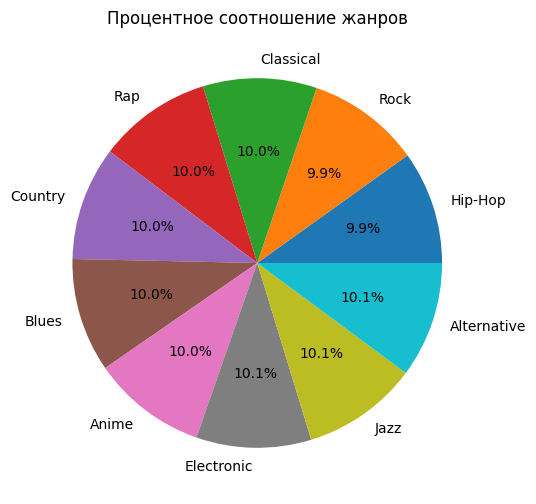

In [ ]:
# построим круговую диаграмму
fig, ax = plt.subplots()
ax.pie(pivot_train['instance_id'], labels= pivot_train['music_genre'], autopct='%1.1f%%')
plt.title('Процентное соотношение жанров')

plt.show()

### Изучим входные признаки

Посмотрим на распределение количественных признаков

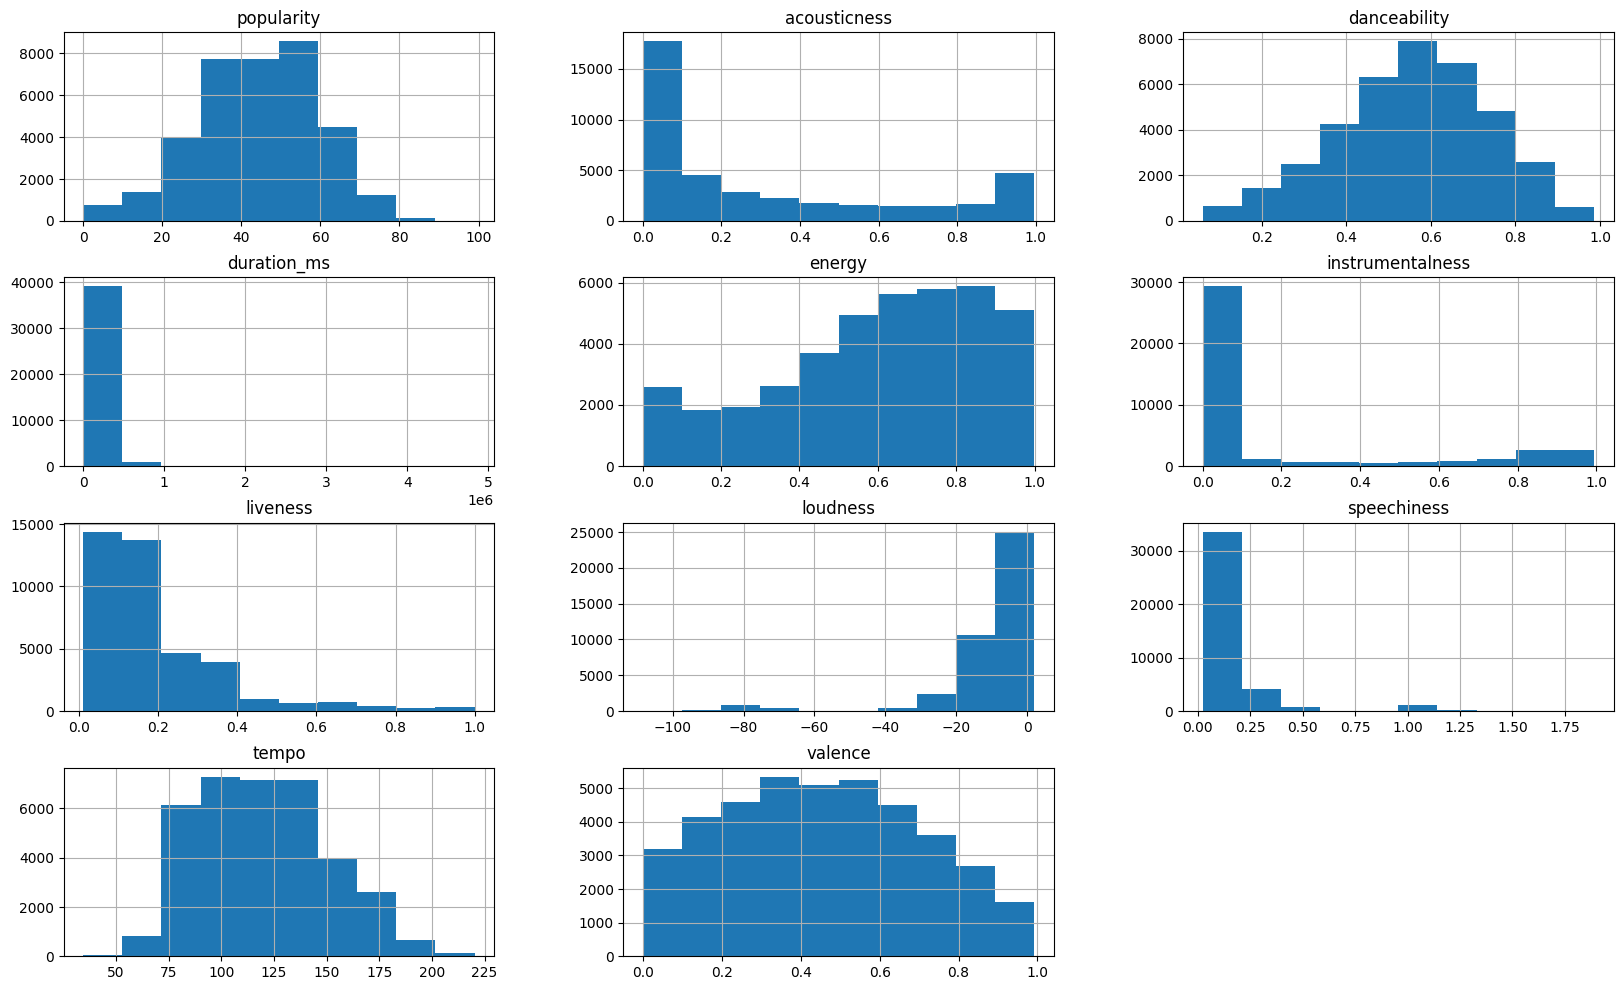

In [ ]:
train.drop(['instance_id'], axis= 1).hist(figsize=(20, 12));

Изучим взаимосвязь между признаками

In [ ]:
!pip install phik -q
import phik

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/686.1 kB ? eta -:--:--
     ━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/686.1 kB 4.8 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━ 501.8/686.1 kB 7.3 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 6.6 MB/s eta 0:00:00


In [ ]:
interval_cols_rate = ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
                      'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
phik_overview_rate = train.drop('instance_id', axis= 1).phik_matrix(interval_cols= interval_cols_rate)
phik_overview_rate

/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable track_name is large: 25972. Are you sure this is not an interval variable? Analysis for pairs of variables including track_name can be slow.
  warnings.warn(


,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
track_name,1.00,0.92,0.95,0.97,0.97,0.95,0.96,0.95,0.96,0.96,0.79,0.00,0.96,0.97,0.95,0.44
popularity,0.92,1.00,0.39,0.38,0.10,0.41,0.39,0.07,0.11,0.28,0.03,0.25,0.13,0.19,0.23,0.80
acousticness,0.95,0.39,1.00,0.49,0.14,0.77,0.48,0.11,0.20,0.55,0.03,0.18,0.34,0.35,0.43,0.67
danceability,0.97,0.38,0.49,1.00,0.16,0.55,0.36,0.11,0.13,0.36,0.10,0.31,0.39,0.37,0.57,0.64
duration_ms,0.97,0.10,0.14,0.16,1.00,0.14,0.16,0.03,0.07,0.22,0.01,0.03,0.05,0.04,0.13,0.18
energy,0.95,0.41,0.77,0.55,0.14,1.00,0.47,0.10,0.27,0.66,0.04,0.18,0.39,0.38,0.51,0.69
instrumentalness,0.96,0.39,0.48,0.36,0.16,0.47,1.00,0.05,0.15,0.38,0.09,0.19,0.23,0.20,0.38,0.58
key,0.95,0.07,0.11,0.11,0.03,0.10,0.05,1.00,0.04,0.10,0.34,0.10,0.04,0.05,0.05,0.17
liveness,0.96,0.11,0.20,0.13,0.07,0.27,0.15,0.04,1.00,0.14,0.03,0.12,0.09,0.07,0.15,0.21
loudness,0.96,0.28,0.55,0.36,0.22,0.66,0.38,0.10,0.14,1.00,0.01,0.11,0.25,0.24,0.34,0.52


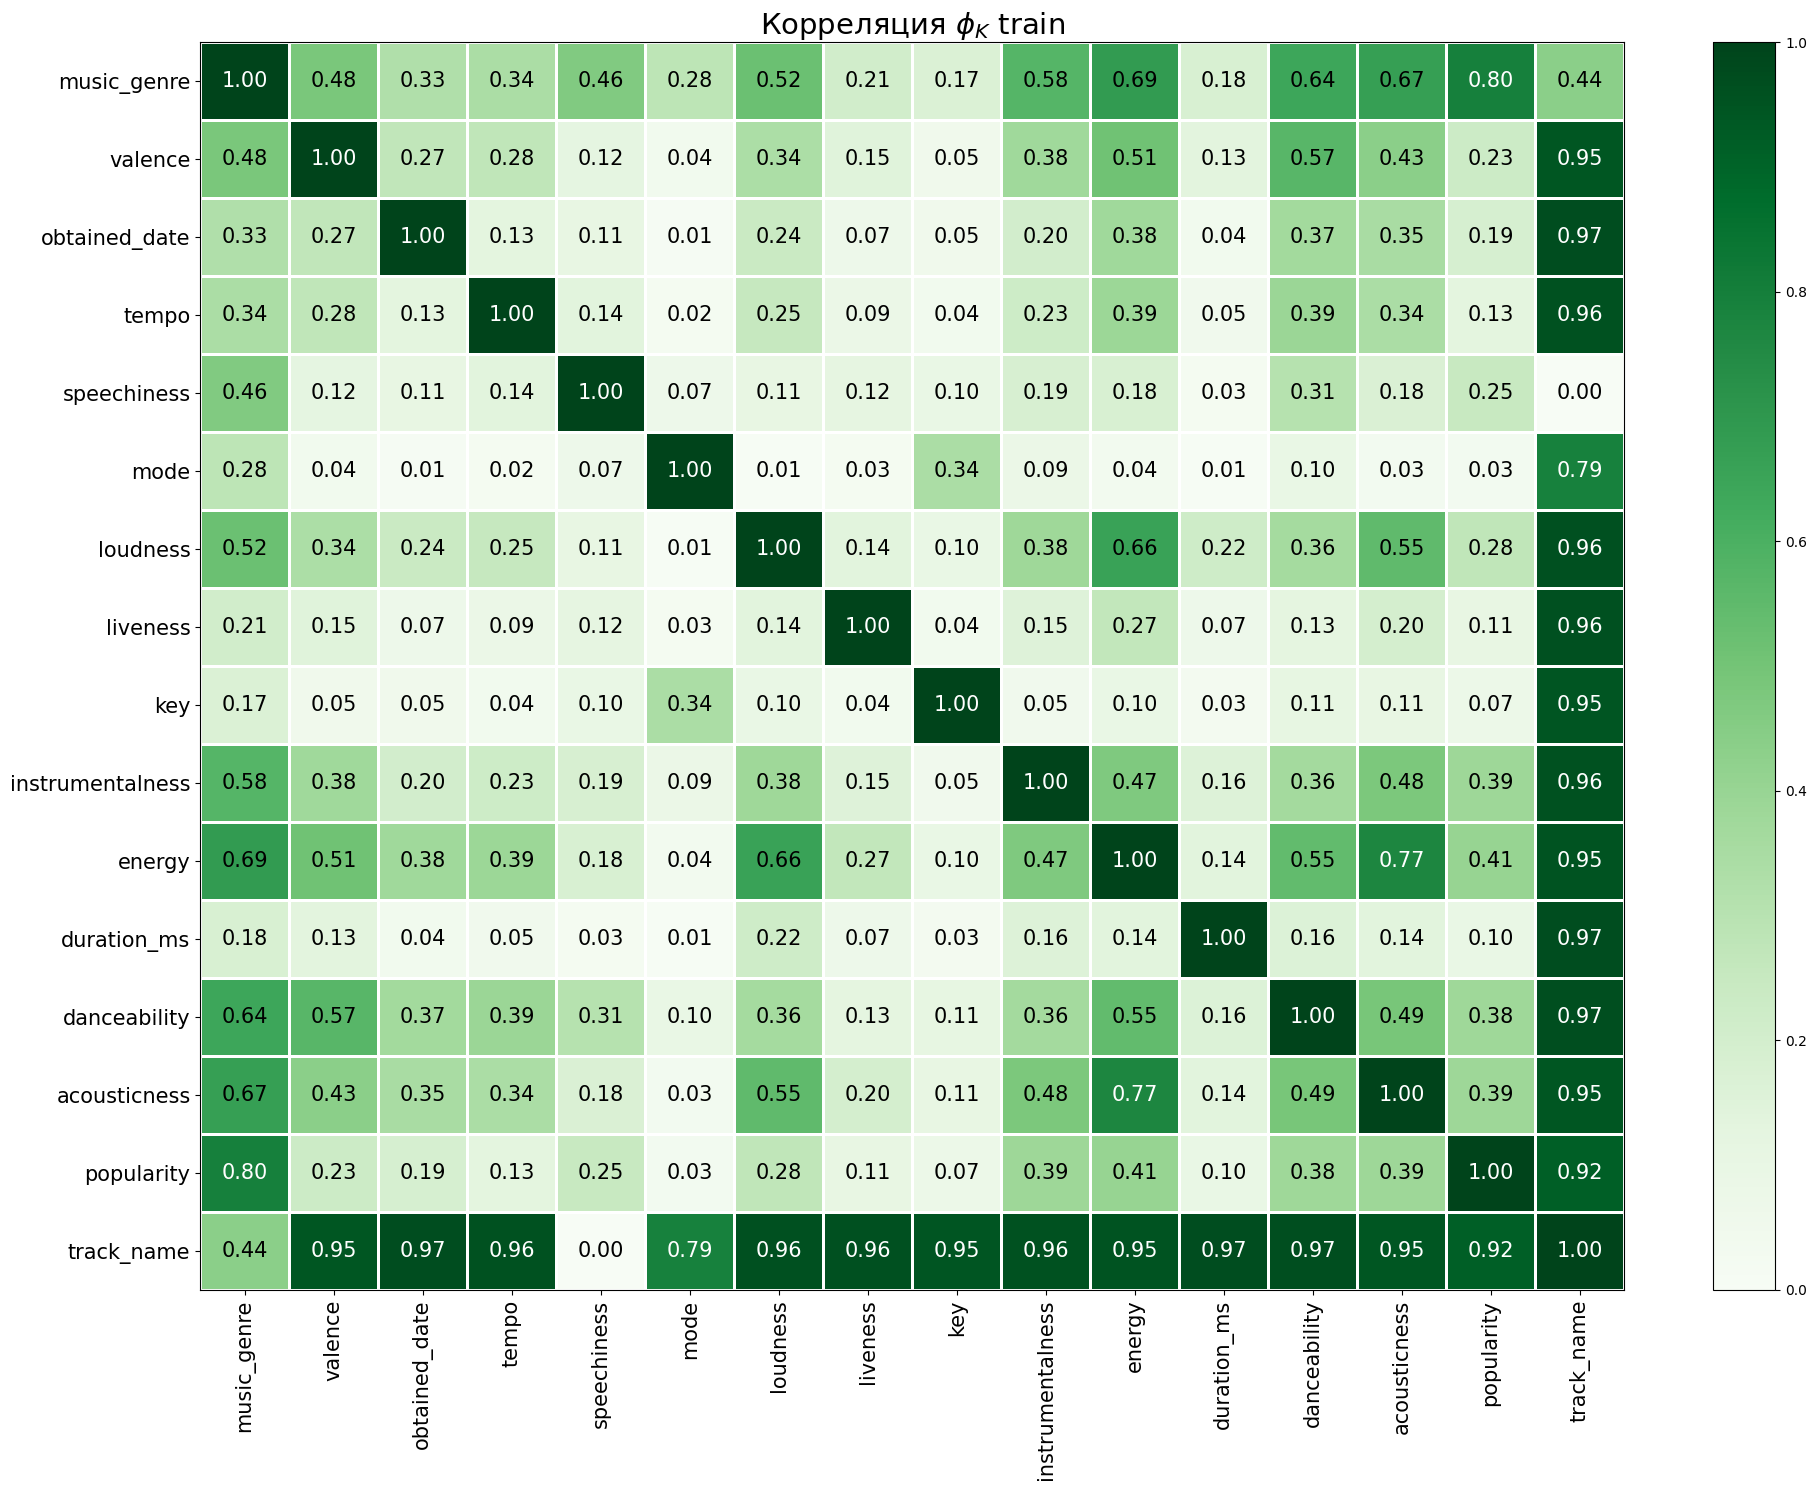

In [ ]:
from phik.report import plot_correlation_matrix

plot_correlation_matrix(
    phik_overview_rate.values,
    x_labels=phik_overview_rate.columns,
    y_labels=phik_overview_rate.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Корреляция $\phi_K$ train',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

Признак `track_name` сильно коррелирует с другими признаками, кроме целевого. Есть смысл его не использовать в исследовании.

Посмотрим на распределение категориальных признаков

In [ ]:
key_train = train.pivot_table(
    index= 'key',
    values= 'instance_id', aggfunc= 'count'
).sort_values(by='instance_id', ascending = True)

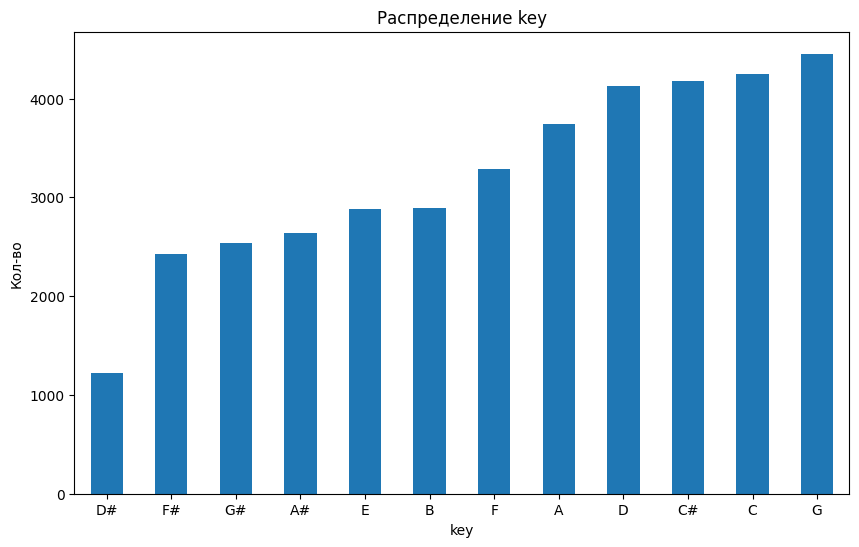

In [ ]:
key_train.plot(kind='bar', legend= False, rot=0)
plt.title('Распределение key')
plt.xlabel('key')
plt.ylabel('Кол-во')
plt.show()

In [ ]:
mode_train = train.pivot_table(
    index= 'mode',
    values= 'instance_id', aggfunc= 'count'
).sort_values(by='instance_id', ascending = True)

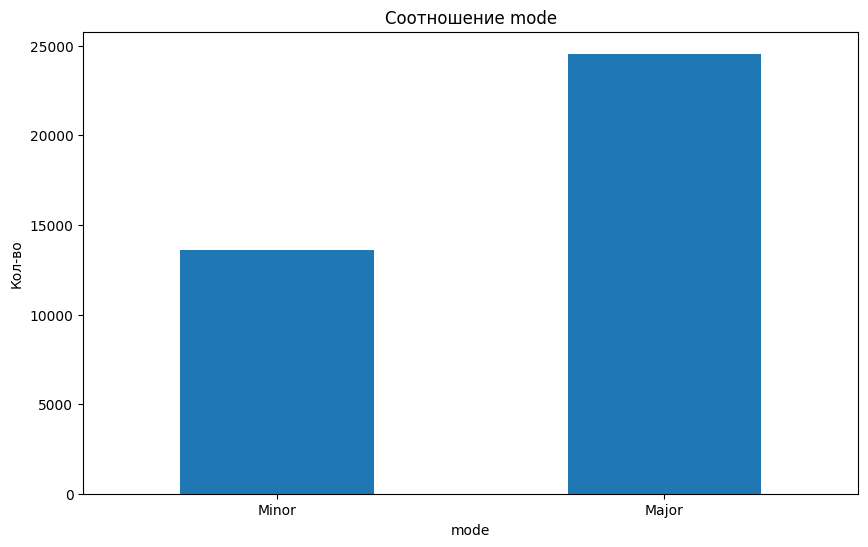

In [ ]:
mode_train.plot(kind='bar', legend= False, rot=0)
plt.title('Соотношение mode')
plt.xlabel('mode')
plt.ylabel('Кол-во')
plt.show()

In [ ]:
obtained_date_train = train.pivot_table(
    index= 'obtained_date',
    values= 'instance_id', aggfunc= 'count'
).sort_values(by='instance_id', ascending = True)

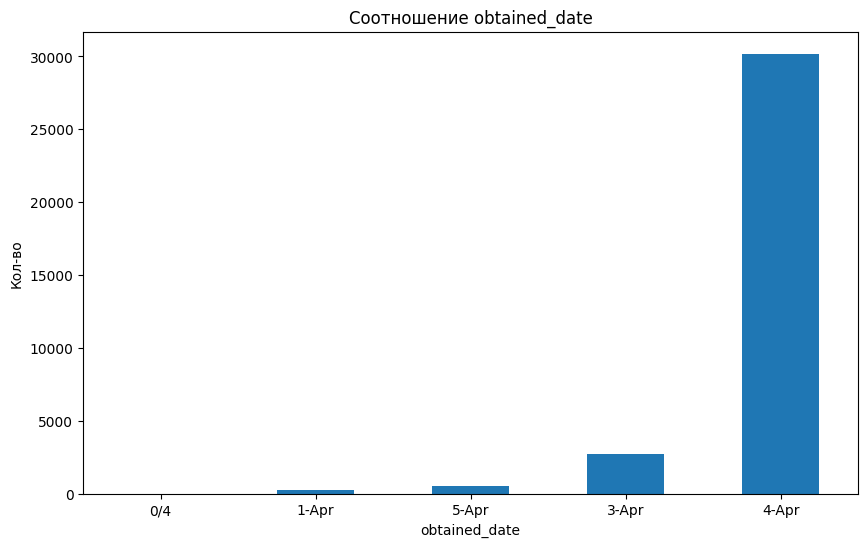

In [ ]:
obtained_date_train.plot(kind='bar', legend= False, rot=0)
plt.title('Соотношение obtained_date')
plt.xlabel('obtained_date')
plt.ylabel('Кол-во')
plt.show()

## Задача классификации

### Подготовка данных

In [ ]:
# сделаем индексами id
test.set_index('instance_id', inplace = True)
train.set_index('instance_id', inplace = True)

In [ ]:
# после этого снова проверим данные на дубликаты
get_duplcate()

Дубликатов в датафрейме train: 0 - это 0.0 от всех данных
Дубликатов в датафрейме test: 19 - это 0.0 от всех данных
Дубликатов в датафрейме sample_submit: 0 - это 0.0 от всех данных


На тренировочной выборке дубликатов нет, тестовую выборку не трогаем.

In [ ]:
# разделим данные на выборки

RANDOM_STATE = 42

X = train.drop(['music_genre', 'track_name', 'obtained_date'], axis=1)
y = train['music_genre']

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, random_state= RANDOM_STATE
)

X_test = test.drop(['track_name', 'obtained_date'], axis=1)

In [ ]:
# кодируем таргет в тренировочной и валидационной выборках
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_valid = le.fit_transform(y_valid)

In [ ]:
y_valid

array([7, 0, 5, ..., 9, 1, 8])

In [ ]:
# введём обозначения для типов исходных данных

ohe_columns = ['mode', 'key']

num_columns = ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
               'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

In [ ]:
# переходим к созданию пайплайна

ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist', sparse_output=False))
    ])

In [ ]:
num_pipe = Pipeline(steps=[
    ('impute', IterativeImputer(max_iter=10, random_state=42)),
    ('scale', RobustScaler()),
    ('drop_correlated_features', DropCorrelatedFeatures(threshold=0.8)),
    ('polynomial_features', PolynomialFeatures(degree=2)),
    ('drop_constant_features', DropConstantFeatures(tol=0.998))
])

In [ ]:
data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('num', num_pipe, num_columns)
])

In [ ]:
# создаем итоговый пайплайн

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state= RANDOM_STATE))
])

### Обучение моделей

In [ ]:
# создаем словарь для перебора гиперпараметров моделей

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5)
    },

    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5)
    },

    # словарь для модели RandomForestClassifier()
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5)
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear', penalty='l1'
        )],
        'models__C': range(2, 15)
    }

]

In [ ]:
randomize = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='f1_micro',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomize.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='infrequent_if_exist',
                                                                                                              sparse_output=False))]),
                                                                               ['mode',
                                                                                'key']),
                                                                              ('num',
                                                                               Pipeline(steps=[('impute',
                                                                                                IterativeImputer(random...
                                         'models__max_depth': range(2, 5),
                                         'models__max_features': range(2, 5)},
                                        {'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': range(2, 5)},
                                        {'models': [RandomForestClassifier(random_state=42)],
                                         'models__max_depth': range(2, 5)},
                                        {'models': [LogisticRegression(C=12,
                                                                       penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(2, 15)}],
                   random_state=42, scoring='f1_micro')

In [ ]:
print('Лучшая модель и её параметры:\n\n', randomize.best_estimator_)
print ('Метрика f1_micro лучшей модели на кросс-валидации:', randomize.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='infrequent_if_exist',
                                                                                 sparse_output=False))]),
                                                  ['mode', 'key']),
                                                 ('num',
                                                  Pipeline(steps=[('impute',
                                                                   IterativeImputer(r

Тестирование лучшей модели

In [ ]:
best_model = randomize
pred_class = best_model.best_estimator_.predict(X_valid)
pred_class

array([2, 5, 1, ..., 9, 1, 7])

In [ ]:
print('Метрика f1_micro на X_valid:', f1_score(y_valid, pred_class, average='micro').round(2))

Метрика f1_micro на X_valid: 0.53


Сделаем итоговые предсказания на тестовой выборке:

In [ ]:
X_valid

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
instance_id,,,,,,,,,,,,,
3867,34.00,0.85,0.62,179933.00,0.73,0.26,F,0.19,-8.40,Major,0.04,129.93,0.86
34597,42.00,0.15,0.52,308178.00,0.49,0.06,E,0.10,-10.43,Minor,0.09,74.79,0.06
26061,35.00,0.00,NaN,264576.00,0.95,0.01,D,0.39,-2.73,Minor,0.08,127.99,0.66
47465,36.00,0.57,0.52,172333.00,0.81,0.00,G,0.12,-5.20,Major,0.03,157.82,0.85
43839,48.00,0.02,0.75,195907.00,0.54,0.08,E,0.22,-8.79,Minor,0.03,101.98,0.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10424,33.00,0.99,0.27,187107.00,0.02,0.83,C,0.07,-28.44,Minor,0.04,74.17,0.03
24877,34.00,0.10,0.61,-1.00,0.77,0.01,A,0.98,-8.37,Major,0.03,107.36,0.40
41727,60.00,0.16,0.63,-1.00,0.78,0.00,G#,0.11,-4.93,Major,0.05,101.07,0.93


In [ ]:
y_pred = best_model.best_estimator_.predict(X_test)
y_pred

array([1, 4, 9, ..., 7, 3, 5])

In [ ]:
y_pred = le.inverse_transform(y_pred)
y_pred

array(['Anime', 'Country', 'Rock', ..., 'Jazz', 'Classical', 'Electronic'],
      dtype=object)

In [ ]:
y_pred_pd = pd.DataFrame(y_pred, columns= ['music_genre']).set_index(X_test.index)
y_pred_pd

,music_genre
instance_id,
32911,Anime
30681,Country
9640,Rock
40204,Rock
11034,Rap
...,...
39792,Electronic
35928,Rock
16758,Jazz


In [ ]:
y_pred_pd = y_pred_pd.reset_index()
y_pred_pd

,instance_id,music_genre
0,32911,Anime
1,30681,Country
2,9640,Rock
3,40204,Rock
4,11034,Rap
...,...,...
9995,39792,Electronic
9996,35928,Rock
9997,16758,Jazz
9998,18788,Classical


In [ ]:
y_pred_pd.to_csv('sample_submission.csv', index= False)

## Общий вывод

**Целью** данного исследования была разработка модели, позволяющей классифицировать музыкальные произведения по жанрам

Для достижения цели мы загрузили и изучили данные, провели их предобработку и исследовательский анализ.

Далее мы подготовили тренировочные и тестовые данные для обучения моделей, с помощью пайплайнов мы кодировали и масштабировали данные, заполнили имеющиеся пропуски. Создали словарь с гиперпараметрами моделей и выбрали для их перебора инструмент RandomizedSearchCV.

Для оценки качества работы модели мы определили метрику F1. Лучшей моделью на кросс-валидации стала логистическая регрессия с параметрами: `LogisticRegression(C=12, penalty='l1', random_state=42, solver='liblinear')` и метрикой F1 на валидационной выборке, равной 0.53.

Используя эту модель, мы сделали итоговые предсказания на тестовых данных и сохранили их в файле `'sample_submission.csv'`.